In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


In [4]:
y_classes = get_yclasses(params, ker_integrals)

# Using Polynomial features

In [5]:
%time polyfeats = poly_featextract(rscl_data, n_splits=[4,5,10], order_fits=[3,3,3], as_df=True)

CPU times: user 21.8 s, sys: 156 ms, total: 22 s
Wall time: 22 s


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [7]:
def fit_RFregressor(X: np.ndarray, y_classes: pd.DataFrame, kfold:int):
    """Fits a RF regressor for all the parameters in y_classes using X and 
    returns the cross-validation scores for X_train and final score on (X_test, y_test)

    Args:
        X : X dataframe that is used to train the model
        y_classes : Pandas dataframe with the predictors-label as the col-name

    Returns: 
        [cv_scores, models, model_scores, y_preds]
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y_classes,
                                                    test_size=0.2, random_state=1,
                                                    stratify=params['stencil_type'] )
    
    cv_scores=[]; models=[]; model_scores=[]; y_preds = [];

    for col in y_train.columns.tolist():
        
        model = RandomForestRegressor(n_estimators=40,
                              min_samples_split=5, max_features=0.5,
                              n_jobs=-1)
        
        print(f"Running cross-validation for {col}")
        cv_scores.append(cross_val_score(model, X_train, y_train[col], cv=kfold,
                                         verbose=1, n_jobs=-1))

        print(f"Training for {col}")
        model.fit(X_train, y_train[col])
        models.append(model)
        print(f"Model fitted for {col}. Now scoring")
        model_scores.append(model.score(X_test, y_test[col]))
        y_preds.append((y_test[col], model.predict(X_test)))
        print()

    return [cv_scores, models, model_scores, y_preds]

In [8]:
regr = fit_RFregressor(polyfeats, y_classes, kfold=10)

Running cross-validation for αx


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.2s finished


Training for αx
Model fitted for αx. Now scoring

Running cross-validation for αz


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.7s finished


Training for αz
Model fitted for αz. Now scoring

Running cross-validation for len_scale


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished


Training for len_scale
Model fitted for len_scale. Now scoring



In [9]:
cv_scores = [f"{regr[0][i].mean():.3} "+r"$\pm$"+f" {regr[0][i].std():.3}" for i in range(len(regr[0]))]
cv_scores

['0.955 $\\pm$ 0.00643', '0.957 $\\pm$ 0.00364', '0.88 $\\pm$ 0.0693']

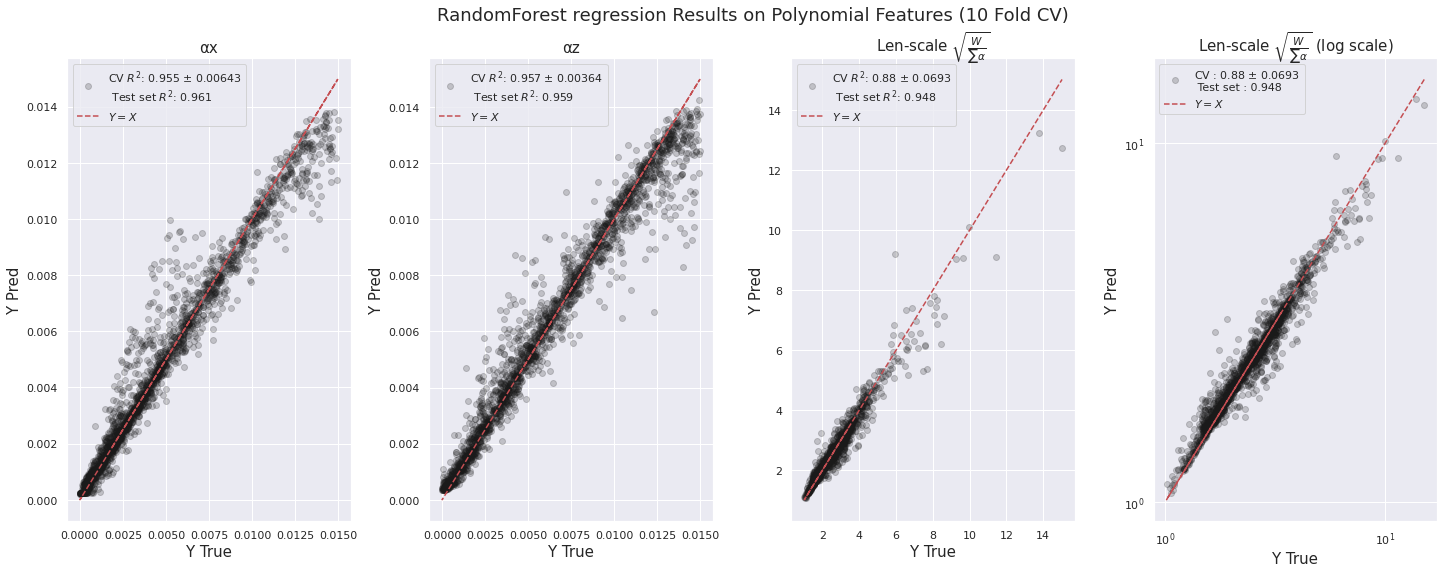

In [10]:
fig, axes = plt.subplots(1,4, figsize=(21,9))

for idx, ax in enumerate(axes):
    if idx <3 :  
        ax.plot(regr[3][idx][0].values, regr[3][idx][1], 'ko', alpha=0.2, label=f"CV $R^2$: {cv_scores[idx]}\n Test set $R^2$: {regr[2][idx]:.3}")
        ax.plot(regr[3][idx][0].values, regr[3][idx][0].values, 'r--', label=r"$Y=X$")
        ax.legend()
        ax.set_title(y_classes.columns.tolist()[idx], fontsize=15)
        ax.set_xlabel('Y True', fontsize=15)
        ax.set_ylabel('Y Pred', fontsize=15)
    else:
        ax.plot(regr[3][2][0].values, regr[3][2][1], 'ko', alpha=0.2, label=f"CV : {cv_scores[2]}\n Test set : {regr[2][2]:.3}")
        ax.plot(regr[3][2][0].values, regr[3][2][0].values, 'r--', label=r"$Y=X$")
        ax.legend()
        ax.set_title(r"Len-scale $\sqrt{\frac{W}{\sum \alpha}}$ (log scale)", fontsize=15)
        ax.set_xlabel('Y True', fontsize=15)
        ax.set_ylabel('Y Pred', fontsize=15)
        plt.yscale("log")
        plt.xscale("log")

axes[2].set_title(r"Len-scale $\sqrt{\frac{W}{\sum \alpha}}$", fontsize=15)

plt.suptitle("RandomForest regression Results on Polynomial Features (10 Fold CV)", fontsize=18)
plt.tight_layout(rect=[0.,0.1,0.96, 0.96])

### Get Feature importances

In [65]:
def get_fi(model, kind):

    if kind == 'timeseries':
        fi = pd.DataFrame(np.array([np.arange(1,301).astype(int),
                                    model.feature_importances_*100 ]).T, 
                        columns=['timestamp','fi'])
        return fi.sort_values('fi', ascending=False)

    if kind == "polyfeatures":
        fi = pd.DataFrame(np.array([polyfeats.columns.tolist(),
                       model.feature_importances_]).T,
             columns=['feature','fi'])
        fi["fi"] = pd.to_numeric(fi["fi"], downcast="float")
        fi['order'] = fi['feature'].apply(lambda x : x.split("_")[-1])
        fi["color"] = fi["order"].replace({'0':'#c70a39','1':'#698bfa','2':'#90e388','3':'y'})

        return fi.sort_values('fi', ascending=False)

In [66]:
class FeaturePlot:
    def __init__(self, ntseries):
        self.ntseries = ntseries

    def get_intervals(self, n_splits:list) -> np.ndarray :
        """Gives the time-interval splits for the number of splits given
        Returns : Dictionary with the n_split as the key and the time-interval stamps as values"""
        split_index = [np.linspace(0, self.ntseries, i+1).astype(np.int32) for i in n_splits]
        intervals = {}
        for idx, interval in zip([4,5,10],split_index):
            intervals[idx] = interval 
        return intervals

In [67]:
def plot_feature(axes, intervals:np.ndarray, feature:tuple, plot_index:int):
    """Given an axes object, plots a line-bar for the given feature of the form (10,5,2) where:
        10 : order of partition 
        5 : the bin of interest in the parition
        2 : order of the polynomial in the given bin
        We choose a color for the order of the polynomial (0th, 1st, 2nd, 3rd)
    Returns : an axes object
    """
    color_arr = ['#c70a39','#698bfa','#90e388','y']

    axes.plot(intervals[int(feature[0])][int(feature[1])-1: int(feature[1])+1],
            [plot_index, plot_index], lw=10,
            color = color_arr[int(feature[2])], label=f"$x^{int(feature[2])}$"
            )
    end_time = [max(intervals[key]) for key in intervals.keys()][0]
    axes.plot([0,end_time],[plot_index+0.5, plot_index+0.5],color=(0,0,0,.2))
    ax.legend()

In [68]:
def fi_df2plot(fi_df: pd.DataFrame, ntop:int, ax):
    """Plots the feature importance plot based on imp_feats data"""

    feats = fi_df.head(ntop)['feature'].values.tolist()[::-1]
    feats = list(map(lambda x  : x.split('_') , feats))

    ax.set(xlabel="Time")
    for idx, feature in enumerate(feats):
        plot_feature(ax, intervals, feature, idx+1)
    return ax

### $\alpha _x$ feature importance

In [69]:
fi_ax = get_fi(regr[1][0], "polyfeatures")

In [70]:
intervals = FeaturePlot(300).get_intervals([4,5,10])

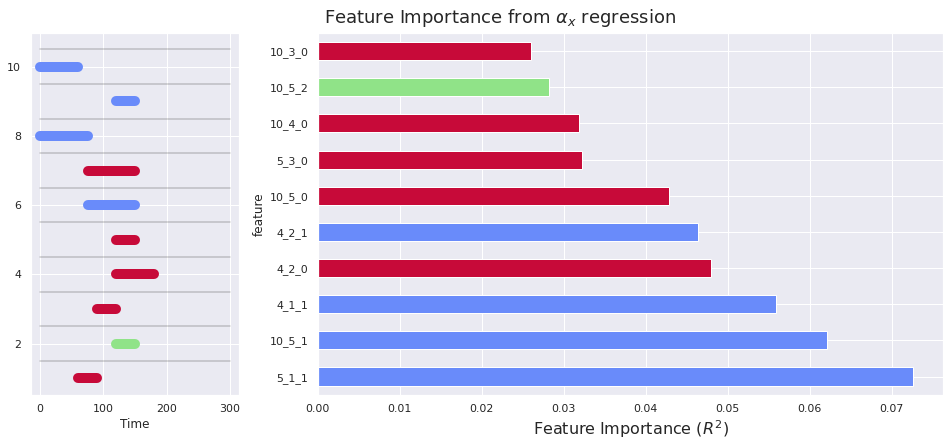

In [71]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(14,7), gridspec_kw={'width_ratios': [1, 3]})

fi_df2plot(fi_ax, 10, a0)

fi_ax.head(10).plot.barh(x='feature', y='fi', ax=a1, color=fi_ax["color"].head(10))
a1.set_xlabel("Feature Importance $(R^2)$", fontsize=16)
a1.get_legend().remove()

plt.suptitle(r"Feature Importance from $\alpha _x$ regression", fontsize=18)
f.tight_layout(rect=[0, 0.1, 0.95, 0.95])
plt.show()

### $\alpha _z$ FI

In [72]:
fi_az = get_fi(regr[1][1], "polyfeatures")

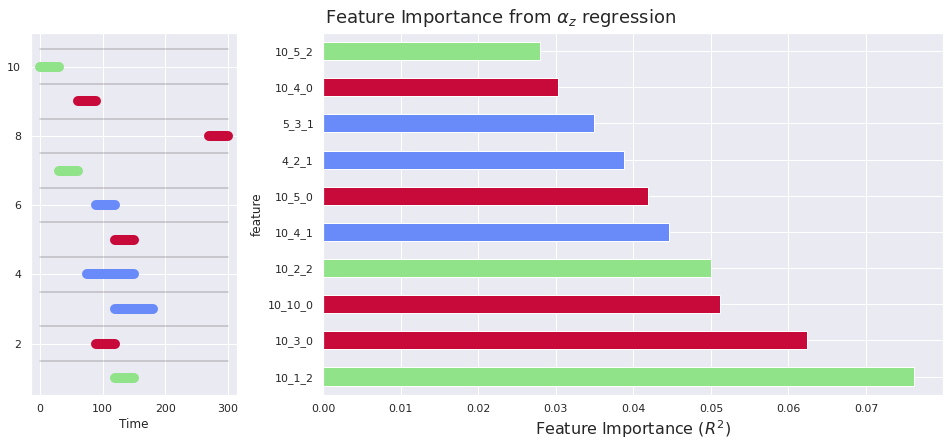

In [73]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(14,7), gridspec_kw={'width_ratios': [1, 3]})

fi_df2plot(fi_az, 10, a0)

fi_az.head(10).plot.barh(x='feature', y='fi', ax=a1, color=fi_az["color"].head(10))
a1.set_xlabel("Feature Importance $(R^2)$", fontsize=16)
a1.get_legend().remove()

plt.suptitle(r"Feature Importance from $\alpha _z$ regression", fontsize=18)
f.tight_layout(rect=[0, 0.1, 0.95, 0.95])
plt.show()

### Length-scale regression

In [74]:
fi_ls = get_fi(regr[1][2], "polyfeatures")

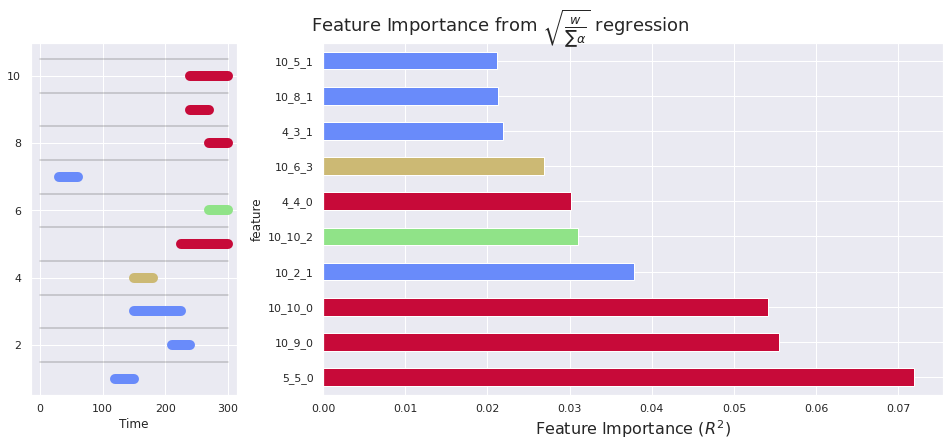

In [75]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(14,7), gridspec_kw={'width_ratios': [1, 3]})

fi_df2plot(fi_ls, 10, a0)

fi_ls.head(10).plot.barh(x='feature', y='fi', ax=a1, color=fi_ls["color"].head(10))
a1.set_xlabel("Feature Importance $(R^2)$", fontsize=16)
a1.get_legend().remove()

plt.suptitle(r"Feature Importance from $\sqrt{\frac{w}{\sum \alpha}}$ regression", fontsize=18)
f.tight_layout(rect=[0, 0.1, 0.95, 0.93])
plt.show()

# All figures combined 

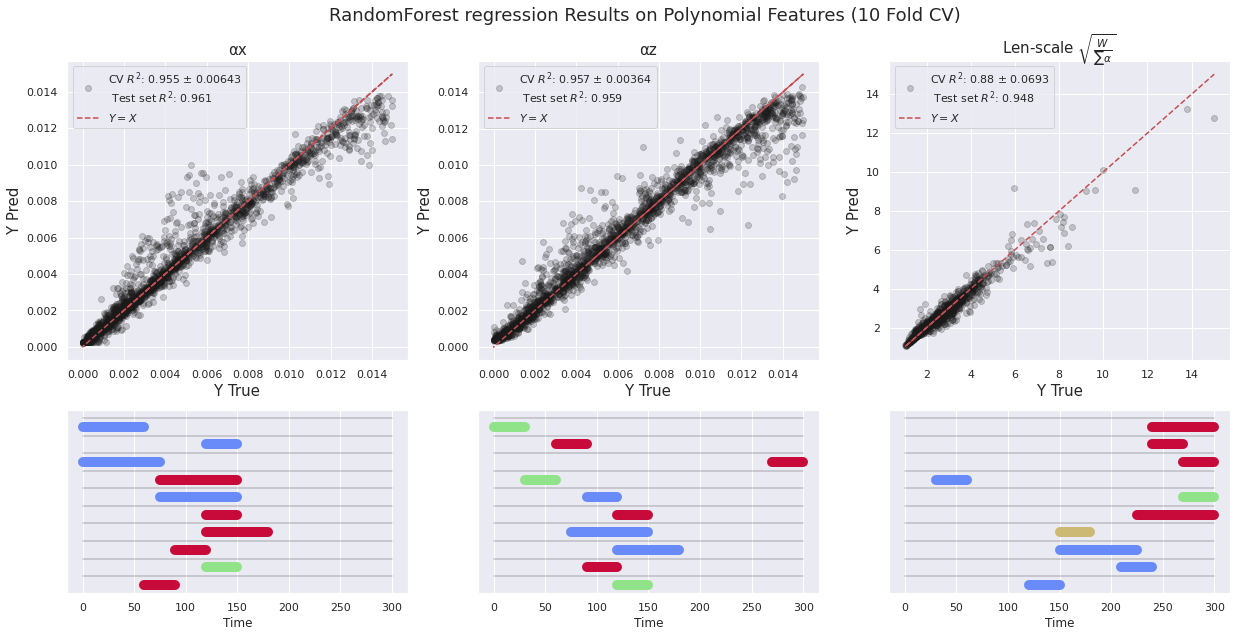

In [76]:
fig = plt.figure(figsize=(18, 10), constrained_layout=False)

ax = fig.add_gridspec(5, 6)

ax1 = fig.add_subplot(ax[0:3, 0:2])
ax2 = fig.add_subplot(ax[0:3, 2:4])
ax3 = fig.add_subplot(ax[0:3, 4:6])
axes = [ax1, ax2, ax3]

ax4 = fig.add_subplot(ax[3:5, 0:2])
ax5 = fig.add_subplot(ax[3:5, 2:4])
ax6 = fig.add_subplot(ax[3:5, 4:6])
axes2 = [ax4,ax5,ax6]



for idx, ax in enumerate(axes): 
    ax.plot(regr[3][idx][0].values, regr[3][idx][1], 'ko', alpha=0.2, label=f"CV $R^2$: {cv_scores[idx]}\n Test set $R^2$: {regr[2][idx]:.3}")
    ax.plot(regr[3][idx][0].values, regr[3][idx][0].values, 'r--', label=r"$Y=X$")
    ax.legend()
    ax.set_title(y_classes.columns.tolist()[idx], fontsize=15)
    ax.set_xlabel('Y True', fontsize=15)
    ax.set_ylabel('Y Pred', fontsize=15)
  
ax3.set_title(r"Len-scale $\sqrt{\frac{W}{\sum \alpha}}$", fontsize=15)

# Feature importance

fis = [fi_ax, fi_az, fi_ls]
for idx,ax in enumerate(axes2):
    fi_df2plot(fis[idx], 10, ax)
    ax.set(yticks=[])
    ax.get_legend().remove()


plt.suptitle("RandomForest regression Results on Polynomial Features (10 Fold CV)", fontsize=18)
plt.tight_layout(rect=[0.,0.1,0.96, 0.96])

# Plot of how r2 depends on features ?

### All FI combined

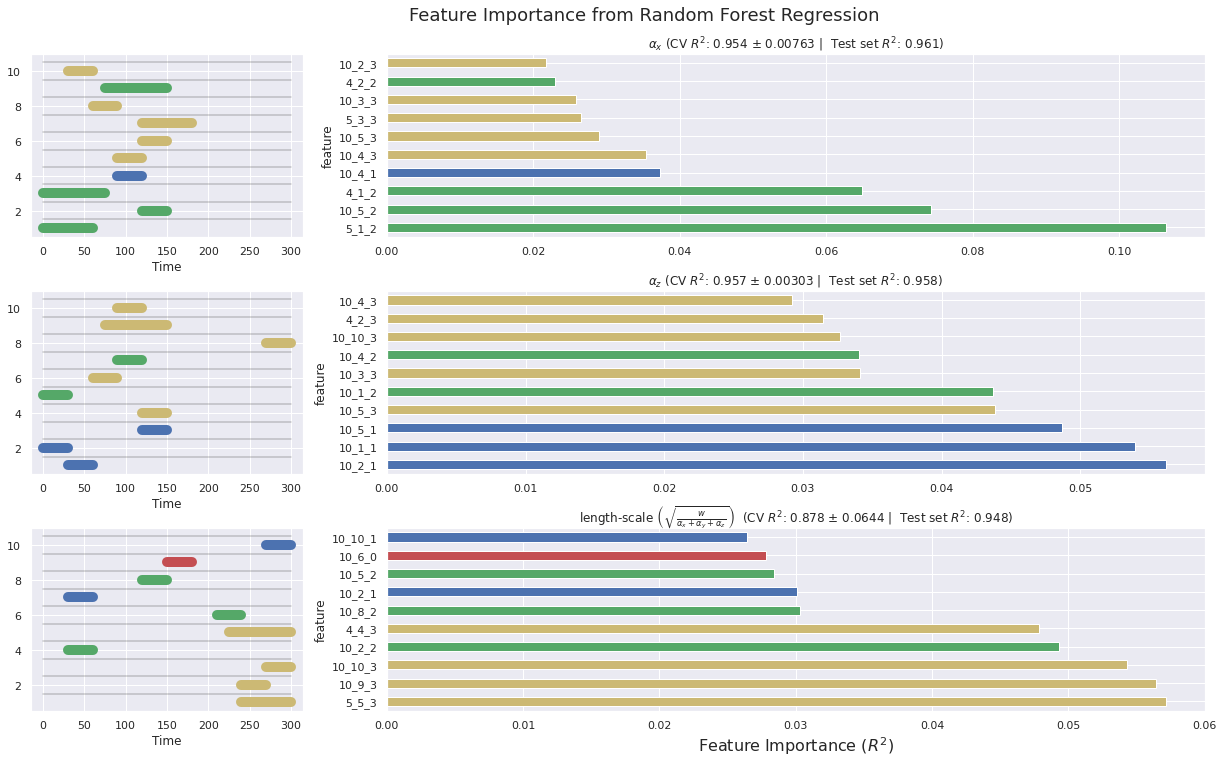

In [ ]:
fig, (a1,a2,a3) = plt.subplots(3,2, gridspec_kw={'width_ratios': [1, 3]},
                                figsize=(18,12) )

### ax
fi_df2plot(fi_ax, 10, a1[0])
fi_ax.head(10).plot.barh(x='feature', y='fi', ax=a1[1], color=fi_ax["color"].head(10))

a1[1].get_legend().remove()
a1[1].set_title(rf"$\alpha _x$ (CV $R^2$: {cv_scores[0]} |  Test set $R^2$: {regr[2][0]:.3})")

### az
fi_df2plot(fi_az, 10, a2[0])
fi_az.head(10).plot.barh(x='feature', y='fi', ax=a2[1], color=fi_az["color"].head(10))
a2[1].get_legend().remove()
a2[1].set_title(rf"$\alpha _z$ (CV $R^2$: {cv_scores[1]} |  Test set $R^2$: {regr[2][1]:.3})")

### len-scale
fi_df2plot(fi_ls, 10, a3[0])
fi_ls.head(10).plot.barh(x='feature', y='fi', ax=a3[1], color=fi_ls["color"].head(10))
a3[1].get_legend().remove()
a3[1].set_title(r"length-scale $ \left( \sqrt{\frac{w}{ \alpha _x + \alpha _y + \alpha _z}} \right) $" +
                f"  (CV $R^2$: {cv_scores[2]} |  Test set $R^2$: {regr[2][2]:.3})")
a3[1].set_xlabel("Feature Importance $(R^2)$", fontsize=16)

plt.suptitle(r"Feature Importance from Random Forest Regression", fontsize=18)
plt.tight_layout(rect=[0, 0.1, 0.95, 0.96])
plt.show()